In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd

import os

In [5]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [7]:
dictionary={0: 'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative DR'}

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [9]:
df_train.shape

(3662, 2)

In [26]:
df_test.shape

(1928, 1)

In [41]:
df_train.isnull().sum()

id_code      0
diagnosis    0
dtype: int64

In [42]:
df_test.isnull().sum()

id_code    0
dtype: int64

In [43]:
data_copy=df_train.copy()

In [44]:
data_copy['diagnosis']=data_copy['diagnosis'].map(dictionary)

In [45]:
data_copy['diagnosis'].value_counts()

No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: diagnosis, dtype: int64

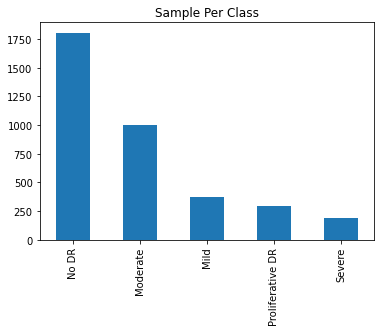

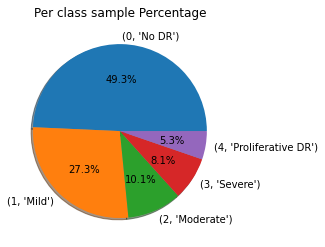

In [46]:
chat_data = data_copy.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True,labels=dictionary.items())
plt.title('Per class sample Percentage');
plt.show()

# img plotting

In [47]:
def view_fundus_images(images, title = ''):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))   
    for im in range(0, height * width):
        # open image
        image = Image.open(os.path.join(r"/content/gdrive/My Drive/ML Projects (Colab)/retina dataset/train_images",images[im] + '.png'))
        i = im // width
        j = im % width
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

    # set suptitle
    plt.suptitle(title)
    plt.show()

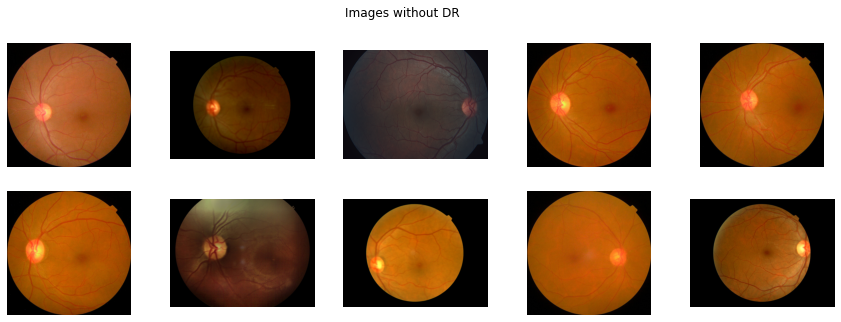

In [48]:
view_fundus_images(df_train[df_train['diagnosis'] == 0][:10].id_code.values, title = 'Images without DR')

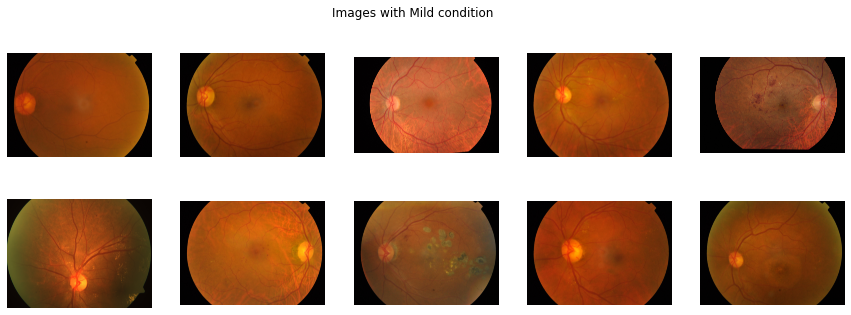

In [49]:
view_fundus_images(df_train[df_train['diagnosis'] == 1][:10].id_code.values, title = 'Images with Mild condition')

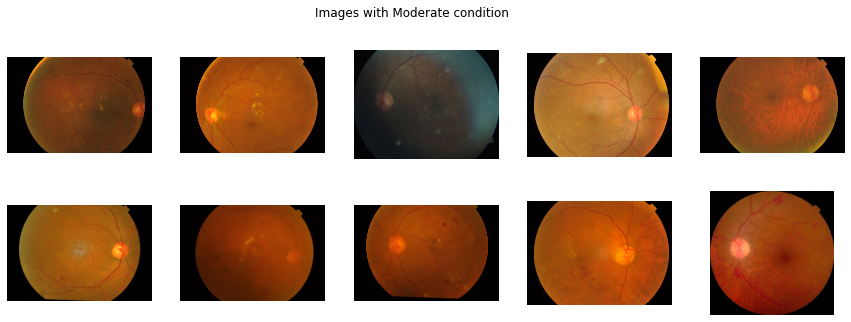

In [50]:
view_fundus_images(df_train[df_train['diagnosis'] == 2][:10].id_code.values, title = 'Images with Moderate condition')

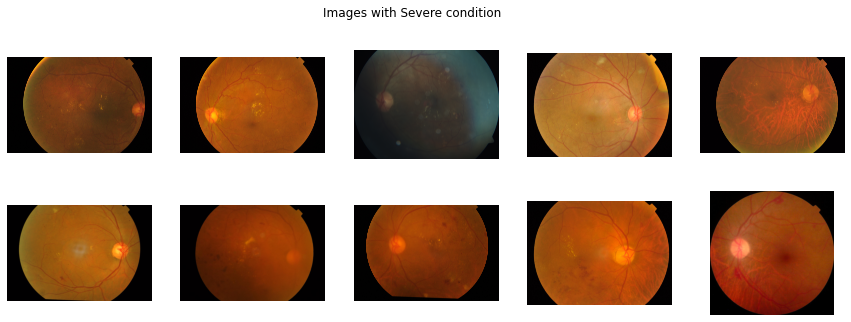

In [51]:
view_fundus_images(df_train[df_train['diagnosis'] == 2][:10].id_code.values, title = 'Images with Severe condition')

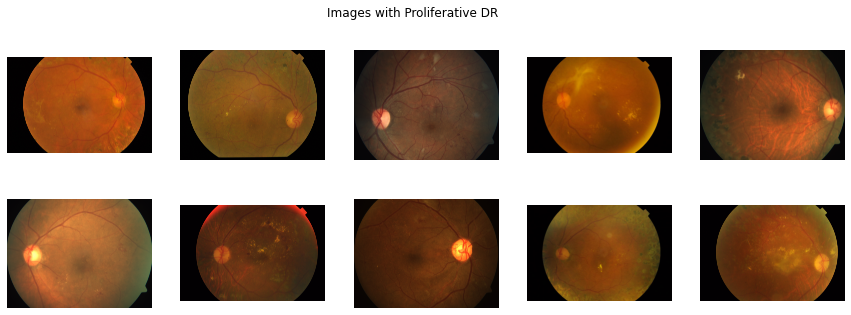

In [52]:
view_fundus_images(df_train[df_train['diagnosis'] == 4][:10].id_code.values, title = 'Images with Proliferative DR')

In [58]:
def img_size(df,train=True):
    if train:
        path=r'/content/gdrive/My Drive/ML Projects (Colab)/retina dataset/train_images'
    else:
        path=r"/content/gdrive/My Drive/ML Projects (Colab)/retina dataset/test_images"
        
    widths=[]
    heights=[]
    
    images=df.id_code
    max_im = Image.open(os.path.join(path, images[0] + '.png'))
    min_im = Image.open(os.path.join(path, images[0] + '.png'))
        
    for im in range(0, len(images)):
        image = Image.open(os.path.join(path, images[im] + '.png'))
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im  

In [59]:
train_widths, train_heights, max_train, min_train = img_size(df_train, train = True)
test_widths, test_heights, max_test, min_test = img_size(df_test, train = False)

KeyboardInterrupt: ignored

In [ ]:
print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

In [ ]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

In [ ]:
plt.imshow(max_train)

In [ ]:
plt.imshow(min_train)

In [ ]:
plt.imshow(max_test)

In [ ]:
plt.imshow(min_test)

In [60]:
df_train['diagnosis']=df_train['diagnosis'].map(dictionary)

In [61]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,Moderate
1,001639a390f0,Proliferative DR
2,0024cdab0c1e,Mild
3,002c21358ce6,No DR
4,005b95c28852,No DR


In [62]:
df_train['diagnosis'].value_counts()

No DR               1805
Moderate             999
Mild                 370
Proliferative DR     295
Severe               193
Name: diagnosis, dtype: int64

In [63]:
df_train['diagnosis'] = df_train['diagnosis'].astype('str')
df_train['id_code'] = df_train['id_code'].astype(str)+'.png'

In [64]:
datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

batch_size = 16
image_size = 96

train_gen=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=r"/content/gdrive/My Drive/ML Projects (Colab)/retina dataset/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    save_format='jpeg',
    target_size=(image_size,image_size),
    subset='training')

val_gen=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=r"/content/gdrive/My Drive/ML Projects (Colab)/retina dataset/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    save_format='jpeg',
    target_size=(image_size,image_size),
    subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [65]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,Moderate
1,001639a390f0.png,Proliferative DR
2,0024cdab0c1e.png,Mild
3,002c21358ce6.png,No DR
4,005b95c28852.png,No DR


In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers

In [67]:
def build_model():
    # create model
    model = Sequential()
    #model.add(GaussianDropout(0.3,input_shape=[96,96,3]))
    model.add(Conv2D(15, (3, 3), input_shape=[96,96,3], activation='relu'))
    model.add(GaussianDropout(0.3))
    model.add(Conv2D(30, (5, 5), activation='relu', kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(50, (5, 5), activation='relu'))
    model.add(Conv2D(50, (7, 7), activation='relu'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l1(0.01)))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])
    return model

In [68]:
model = build_model()

In [69]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
mc = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 15)        420       
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, 94, 94, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 30)        11280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 30)        8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 30)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 17, 50)       

In [71]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_gen.n//val_gen.batch_size

In [72]:
model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks = [es, mc], 
                    verbose=1)

Epoch 1/50
183/183 [==============================] - 1633s 9s/step - loss: 4.1098 - accuracy: 0.4986 - val_loss: 2.6232 - val_accuracy: 0.4625

Epoch 00001: val_loss improved from inf to 2.62323, saving model to model.h5
Epoch 2/50
183/183 [==============================] - 1552s 8s/step - loss: 2.1274 - accuracy: 0.5395 - val_loss: 1.9628 - val_accuracy: 0.4693

Epoch 00002: val_loss improved from 2.62323 to 1.96281, saving model to model.h5
Epoch 3/50
183/183 [==============================] - 1751s 10s/step - loss: 1.5442 - accuracy: 0.6455 - val_loss: 1.3616 - val_accuracy: 0.6494

Epoch 00003: val_loss improved from 1.96281 to 1.36162, saving model to model.h5
Epoch 4/50
183/183 [==============================] - 1625s 9s/step - loss: 1.3306 - accuracy: 0.6747 - val_loss: 1.5718 - val_accuracy: 0.6718

Epoch 00004: val_loss did not improve from 1.36162
Epoch 5/50
183/183 [==============================] - 1649s 9s/step - loss: 1.2367 - accuracy: 0.6887 - val_loss: 1.0414 - val_ac

KeyboardInterrupt: ignored

In [75]:
model.evaluate_generator(generator=val_gen,steps=STEP_SIZE_VALID)

[1.0830421447753906, 0.6958333253860474]